In [1]:
##Run this on the terminal to create a new environment, or use the flag --yes (install without confirmation). Will create a yml file at some point.
#conda env create -f environment.yml


from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu

In [10]:
%load_ext autoreload
%autoreload 1
%aimport common_functions
%aimport common_variables
%aimport common_simulation

# All functions and imports are inside common_functions
from common_variables import *
from common_functions import *
from common_simulation import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

Cleaned from the Heroku database in the first notbeook (1_data_cleaning)

In [ ]:
results = pd.read_csv(f'{path_data_files}/data_final/cleaned_combined_data.csv')

# Similarity original story
results_jac = pd.read_csv(f'{path_data_files}/data_processing/analysis_similarity_jaccard.csv')
results_trans = pd.read_csv(f'{path_data_files}/data_processing/analysis_similarity_transformers.csv')

# Similarity between replicates
sim_ind = pd.read_csv(f'{path_data_files}/data_processing/analysis_similarity_ind_jaccard.csv')
sim_trans = pd.read_csv(f'{path_data_files}/data_processing/analysis_similarity_ind_transformers.csv')

## Descriptive:
### Plot number of words

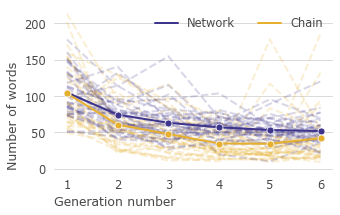

In [4]:
# Calculate words
results["n_words"] = results["story_merged"].apply(lambda x: len(x.split()))

# Plot indiviudal traces
plot_agg(results, x="layer_n",y="n_words",hue="condition")

# Plot average
sns.lineplot(x="layer_n",y="n_words",hue="condition", estimator=np.mean,
             palette=cond2color, data=results,lw=2,marker="o",markersize=7,ci=None)

# Standard style + label
set_style("Number of words")

# Save plot
plt.savefig(f"{path_figures}/h2_number_words.pdf", bbox_inches="tight")

# Figure 2: networks are more consistent

## Similarity

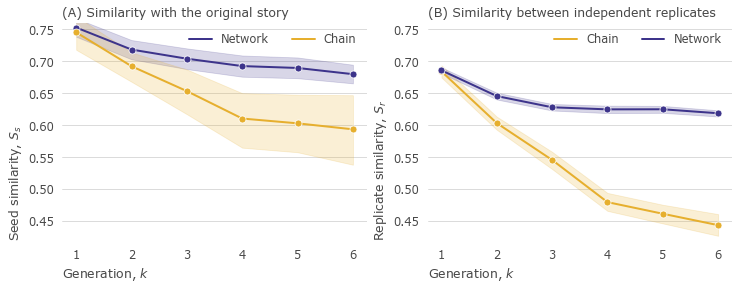

In [5]:
## Figure 2 (network are more consistent)
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
# plot_agg(results_trans, x="layer_n",y="sim_original_story",hue="condition")
# sns.lineplot(x="layer_n",y="sim_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1, ci=None)
sns.lineplot(x="layer_n",y="sim_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1)#, ci=None)
set_style(r"Seed similarity, $S_s$")
ax1.set_title("(A) Similarity with the original story", loc="left")
ax1.set_ylim(0.42,0.76)
ax1.set_xlabel(r"Generation, $k$")

ax2 = plt.subplot(122)
plot_similarity_indep_replicates(sim_trans, ax=ax2)
set_style(r"Replicate similarity, $S_r$")
ax2.set_title("(B) Similarity between independent replicates", loc="left")
ax2.set_ylim(0.42,0.76)
ax2.set_xlabel(r"Generation, $k$")
#plt.suptitle("Participants in the network condition remember more consistent inormation", ha="left", x=0.08, y=1.01)
plt.savefig(f"{path_figures}/fig_2_ci_network_consistent.pdf", bbox_inches="tight")

## Embeddings

In [6]:
# Plot 2D embeddings
data = results.loc[:, ["layer_n","rep","condition","story_merged"]]
data.loc[9909] = [8,0,"Full",story_original]
data["k"] = data.index%3
data.loc[data["condition"].str.contains("Chain"),"k"] = 0

emb_df = pd.read_csv(f"{path_text_embeddings}/story_embeddings.csv")
X_embedded = np.load(f"{path_text_embeddings}/X_story_embedded_umap.npy")

#Add embeddings to data
data["x"] = X_embedded[:,0]
data["y"] = X_embedded[:,1]

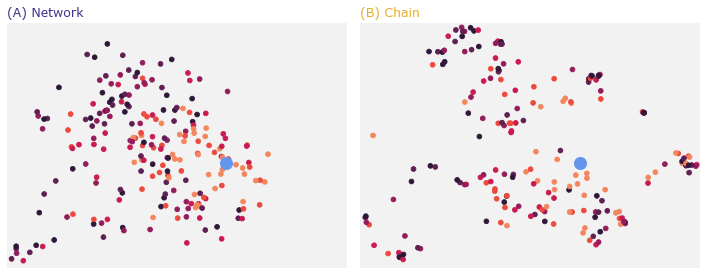

In [7]:
# Main (should have used a seed, looks slightly different than in the paper)
plot_transmissions(data.groupby(["rep","layer_n","condition"]).mean().reset_index(), X_embedded, traces=False)
plt.savefig(f"{path_figures}/umap_mean.pdf", bbox_inches="tight")


In [8]:
# Manual interpretation
data.loc[(data["x"]>1) & (data["y"]>1)  & (data["x"]<4)  & (data["layer_n"]>4) & (data["condition"]=="Network"), "story_merged"].head(4).values

array([], dtype=object)

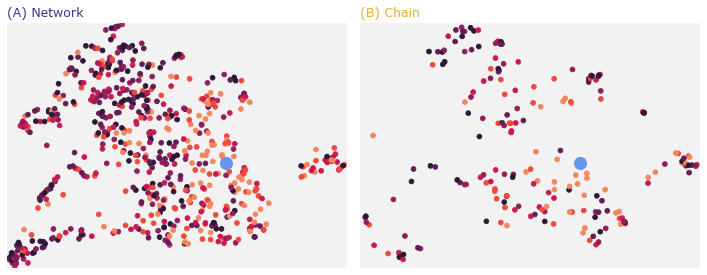

In [9]:
## Appendix
plot_transmissions(data, X_embedded, traces=False)
plt.savefig(f"{path_figures}/umap.pdf", bbox_inches="tight")

/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_76288/2572846927.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  average_embeddings = emb_df.groupby(["condition","k","layer_n"]).transform(np.mean)


MannwhitneyuResult(statistic=5551.0, pvalue=1.2084430771677279e-09)


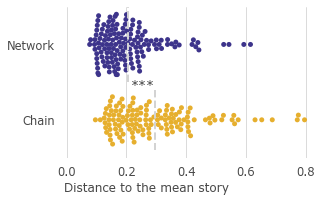

In [10]:
## Appendix
# Difference between network and chain
emb_df = emb_df.loc[emb_df["k"]==0] #consider 1 replicate per network (avoid correlations, biased SE)
emb_df = emb_df.reset_index(drop=True)
# Compare with mean value
average_embeddings = emb_df.groupby(["condition","k","layer_n"]).transform(np.mean)

col_emb = [str(_) for _ in range(768)] if "1" in list(emb_df.columns) else range(768)
for i in range(len(emb_df)):
    emb_df.loc[i, "distance"] = 1-cosine_similarity([emb_df.loc[i, col_emb].values], [average_embeddings.loc[i, col_emb].values])[0][0]
emb_df.head()

xmin,ymin,xmax,ymax = np.concatenate([X_embedded.min(0)*1.1,X_embedded.max(0)*1.1])


d_comp = emb_df.loc[(emb_df["condition"]!="Full") & (emb_df["layer_n"]>=-3+comparison_layer)]
sns.catplot(y="condition",x="distance",data=d_comp, kind="swarm",palette=cond2color,
           aspect=1.6,height=3)

n = d_comp.loc[d_comp["condition"]=="Network", "distance"]
c = d_comp.loc[d_comp["condition"]=="Chain", "distance"]
print(mannwhitneyu(n, c, alternative="less"))
plt.plot([n.mean(),n.mean()],[0.5,-0.5],  "--", color="lightgray", zorder=9)
plt.plot([c.mean(),c.mean()],[0.6,1.4],  "--", color="lightgray", zorder=9)
plt.annotate("***", (0.255, 0.55), ha="center", va="center")

plt.xlabel("Distance to the mean story", fontsize=12)
plt.ylabel("")
plt.gca().grid(axis="x")
sns.despine(left=True, bottom=True)
plt.xlim(-0.01, 0.81)
plt.tight_layout
plt.savefig(f"{path_figures}/fig_spread.pdf", bbox_inches="tight")

## Robustness tests Jaccard/Open AI, Google Universal Encoder
--> see v3_robustness.ipynb

# Figure 3

## Compare advantage of network depending if the word was read 1, 2 or 3 times

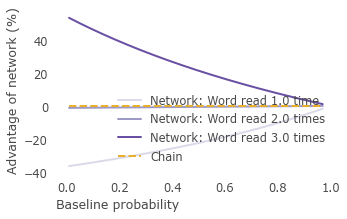

In [11]:
prob = np.linspace(0.01,0.97,1000)

n_remembered = 1
r_chain = create_prob(prob, network=0, n_remembered=n_remembered)
colors = sns.color_palette("Purples",3)

for n_remembered in np.arange(1,4)/3:
    r = create_prob(prob, network=1, n_remembered=n_remembered)

    plt.plot(prob, 100*(r/r_chain - 1), label=f"Network: Word read {3*n_remembered} time{['s',''][int(3*n_remembered==1)]}", color=colors.pop(0))



plt.plot(prob, 100*(r_chain/r_chain - 1), "--", label="Chain", color=palette[1])
    
plt.legend(loc=4)
plt.xlabel("Baseline probability")
plt.ylabel("Advantage of network (%)")

plt.savefig(f"{path_figures}/statistical_model_r.pdf", bbox_inches="tight") 


## Run simulations

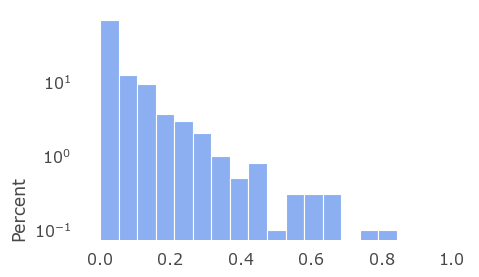

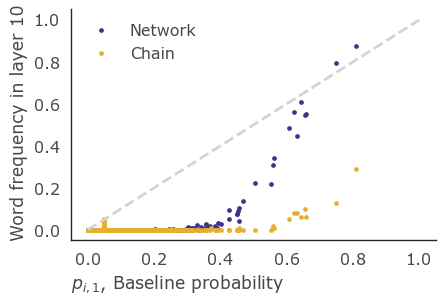

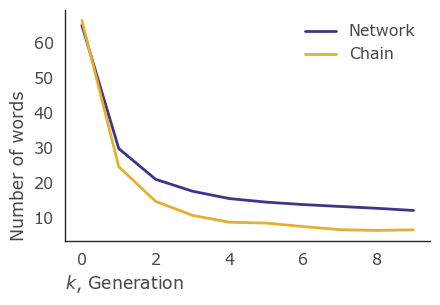

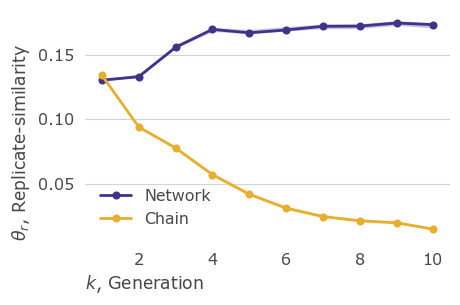

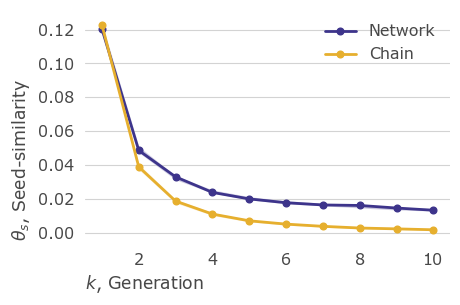

In [13]:
n_reps=100 # Number of replicates of each condition
seed_length=500 # length of original seed text
layers=10 # number of generations in each condition
extra_w=500 # length of dictionary of new words that can be added by participants into the text
extra_intro_rate = 0.01 # probability for new words from the dictionary to be added in
extra_baseline_prob = 0.05 # baseline probability (prior) of newly added words from the dictionary


# GENERATE BASELINE TRANSMISSION PROBABILITIES FROM A BOUNDED EXPONENTIAL FITTED FROM THE DATA
prob = fitted_exponential(story_length_=seed_length,minval=0,maxval=0.9)
simulate_experiment(prob=prob, n_reps=n_reps, seed_length=seed_length, layers=layers, 
                    extra_w = extra_w, extra_intro_rate = extra_intro_rate, 
                    extra_baseline_prob = extra_baseline_prob)

In [46]:
# from dataclasses import dataclass
# @dataclass
# class ModelData:
#     beta_n_observed: float #increase with fraction of previous stories with the word
#     beta_network: float #fixed effect on network condition
#     beta_n_words: float #decay on number of words read
#     story_length: int 

# # This comes from the R code
# model_data = ModelData(
#     beta_n_observed=1.337,
#     beta_network=0.59321,
#     beta_n_words=-0.14566,
#     story_length=265
# )

# def simulate_experiment(baseline_probs, layers = 6, seed_length=265, n_reps = 100, extra_w = 200, introduction_rate = 0.05, 
#                         kept_rate = 0.1, beta_n_observed=model_data.beta_n_observed):
    
# #     base_freqs = pd.read_csv(path_survival_analysis, sep="\t")
# #     # GENERATE BASELINE TRANSMISSION PROBABILITIES FROM A BOUNDED EXPONENTIAL FITTED FROM THE DATA
# #     loc, scale = sp.stats.expon.fit(base_freqs["baseline_prob_3_word_265"], floc=0)
# #     np.random.seed(2018)
# #     prob = bdd_exponential(story_length_=model_data.story_length,decay=1/scale,minval=0,maxval=0.95)
    
# #     ## ADD IN EXTRA WORDS
#     prob = np.concatenate([baseline_probs, kept_rate+np.zeros(extra_w)])
#     total_length = seed_length + extra_w
    
#     prob=baseline_probs
#     # define error bar capsize
#     cs=10

#     # Define transmission computation type
#     type_ = "integrate"

#     all_results_n = []
#     all_results_c = []

#     # Run simulation
#     for i in range(n_reps):
        
#         sc = simulate_chain(prob,beta_n_observed=beta_n_observed, story_length=total_length,layers=layers,introduction_rate=introduction_rate)
#         sn = simulate_net(prob,beta_n_observed=beta_n_observed, story_length=total_length,layers=layers,introduction_rate=introduction_rate)
#         all_results_n.append(sn)
#         all_results_c.append(sc)

#     results_n = np.zeros((n_reps,total_length))
#     results_c = np.zeros((n_reps,total_length))
#     words_n = np.zeros((n_reps,layers))
#     words_c = np.zeros((n_reps,layers))

#     # Calculate similarities
#     for i in range(n_reps): 
#         results_n[i,:] = all_results_n[i][:, -1, :].mean(1)
#         results_c[i,:] = all_results_c[i][:, -1]
#         words_n[i,:] = all_results_n[i].mean(2).sum(0)
#         words_c[i,:] = all_results_c[i].sum(0)

#     results_n = results_n.mean(0)
#     results_c = results_c.mean(0)
    
#     fig1 = plt.figure(figsize=(5,3))
#     fig2 = plt.figure(figsize=(5,3))
#     fig3 = plt.figure(figsize=(5,3))
#     fig4 = plt.figure(figsize=(5,3))


#     ylabel=True
#     ax1 = fig1.add_subplot(111)
#     ax1.plot(prob,results_n,".",label="Network",color=cond2color["Network"])
#     ax1.plot(prob,results_c,".",label="Chain",color=cond2color["Chain"])
#     ax1.legend()
#     ax1.set_xlabel("Probability of propagation")
#     if ylabel:
#         ax1.set_ylabel(f"Word frequency in layer {layers}")
#     ax1.plot([0,1],[0,1],"--",color="lightgray")
#     sns.despine(ax=ax1, bottom=True, left=True)
#     ax1.grid(axis="y")

#     ax2 = fig2.add_subplot(111)
#     ax2.plot(range(layers),words_n.mean(0),label="Network",color=cond2color["Network"])
#     ax2.plot(range(layers),words_c.mean(0),label="Chain",color=cond2color["Chain"])
#     ax2.legend()
#     ax2.set_xlabel("Generation")
#     if ylabel:
#         ax2.set_ylabel("Number of words")
#     sns.despine(ax=ax2, bottom=True, left=True)
#     ax2.grid(axis="y")

#     sim_n = calculate_similarity(all_results_n) #, fun="std")
#     sim_c = calculate_similarity(all_results_c) #, fun="std")
#     sim_n_ci_lower,sim_n_ci_upper=calculate_sim_ci(all_results_n)
#     sim_c_ci_lower,sim_c_ci_upper=calculate_sim_ci(all_results_c)
#     yerr_n=np.empty((2,layers))
#     yerr_n[0,:]=sim_n-np.array(sim_n_ci_lower)
#     yerr_n[1,:]=np.array(sim_n_ci_upper)-sim_n
#     yerr_c=np.empty((2,layers))
#     yerr_c[0,:]=sim_c-np.array(sim_c_ci_lower)
#     yerr_c[1,:]=np.array(sim_c_ci_upper)-sim_c

#     ax3 = fig3.add_subplot(111)
#     ax3.plot(range(1, layers+1),sim_n,label="Network",marker='o',color=cond2color["Network"])
#     ax3.fill_between(range(1, layers+1), y1=sim_n_ci_lower,y2=sim_n_ci_upper, alpha=0.3)
#     ax3.plot(range(1, layers+1),sim_c,label="Chain",marker='o',color=cond2color["Chain"])
#     ax3.fill_between(range(1, layers+1), y1=sim_c_ci_lower,y2=sim_c_ci_upper, alpha=0.3)
#     ax3.legend()
#     ax3.set_xlabel("Generation")
#     if ylabel:
#         ax3.set_ylabel("Similarity between\nindependent replicates")
#     sns.despine(ax=ax3, bottom=True, left=True)
#     ax3.grid(axis="y")

#     sim_n = calculate_similarity(all_results_n, original=True) #, fun="std")
#     sim_c = calculate_similarity(all_results_c, original=True) #, fun="std")
#     sim_n_ci_lower,sim_n_ci_upper=calculate_sim_ci(all_results_n, original=True)
#     sim_c_ci_lower,sim_c_ci_upper=calculate_sim_ci(all_results_c, original=True)
#     yerr_=np.empty((2,layers))
#     yerr_n[0,:]=sim_n-np.array(sim_n_ci_lower)
#     yerr_c[1,:]=np.array(sim_n_ci_upper)-sim_n

#     ax4 = fig4.add_subplot(111)
#     ax4.plot(range(1, layers+1),sim_n,label="Network",marker='o',color=cond2color["Network"])
#     ax4.fill_between(range(1, layers+1), y1=sim_n_ci_lower,y2=sim_n_ci_upper, alpha=0.3)
#     ax4.plot(range(1, layers+1),sim_c,label="Chain",marker='o',color=cond2color["Chain"])
#     ax4.fill_between(range(1, layers+1), y1=sim_c_ci_lower,y2=sim_c_ci_upper, alpha=0.3)
#     ax4.legend()
#     ax4.set_xlabel("Generation")
#     if ylabel:
#         ax4.set_ylabel("Similarity with the \noriginal story")
#     sns.despine(ax=ax4, bottom=True, left=True)
#     ax4.grid(axis="y")


#     # fig1.savefig(f"{figures_path}sim_cm1.pdf", bbox_inches="tight")   
#     # fig3.savefig(f"{figures_path}sim_cm2.pdf", bbox_inches="tight")   
#     fig3.savefig(f"{path_figures}sim_cm3.pdf", bbox_inches="tight")   
#     fig4.savefig(f"{path_figures}sim_cm4.pdf", bbox_inches="tight")  



In [9]:
# # Data from multilevel model (to fit the bounded exponential)
# import scipy as sp
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# # import common_simulation as CS
# from common_simulation import *

# # base_freqs = pd.read_csv(path_survival_analysis, sep="\t")

# path_baseline_probs="../data/word_baseline_probs.csv"
# base_freqs = pd.read_csv(path_baseline_probs, sep="\t")

# # Estimated using multilevel model
# sns.histplot(base_freqs["baseline_prob_3_word_265"], bins=np.linspace(0,1,20), color="k", stat="percent")

# # GENERATE BASELINE TRANSMISSION PROBABILITIES FROM A BOUNDED EXPONENTIAL FITTED FROM THE DATA
# loc, scale = sp.stats.expon.fit(base_freqs["baseline_prob_3_word_265"], floc=0)
# np.random.seed(2018)
# prob = bdd_exponential(story_length_=model_data.story_length,decay=1/scale,minval=0,maxval=0.95)
# #prob = np.random.random(200)/1.1
# sns.histplot(prob, bins=np.linspace(0,1,20), color="cornflowerblue", stat="percent")
# plt.yscale("log")


## Comparing rules of information integration.

Text(0, 0, 'Frequency word (generation 6)')

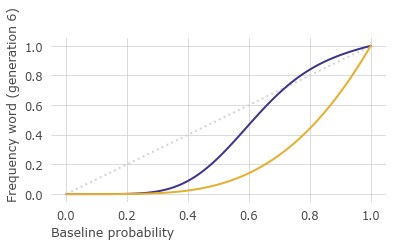

In [17]:
# Calculate the likelihood of transmission for ge using a deterministic model
n_generations = 6


probs = np.linspace(0.001,1,100)
adjusted_probs_after = [create_probs(_, n_words = 61.91, network=1) for _ in probs] 
adjusted_probs_after_c = [create_probs(_, n_words = 15.57*3, network=0)[-1] for _ in probs] #*3 because create_probs already adjusts the probabilities by a 3 factor


time_to_extinguishment = [deterministic_model(_1, _2, max_generations=n_generations) for _1,_2 in zip(probs,adjusted_probs_after)]
time_to_extinguishment = [_ if np.isfinite(_) else n_generations for _ in time_to_extinguishment]

time_to_extinguishment_c = [p*p_af**(n_generations-1) for p,p_af in zip(probs, adjusted_probs_after_c)]
time_to_extinguishment_c = [_ if np.isfinite(_) else n_generations for _ in time_to_extinguishment_c]
plt.figure(figsize=(6,3))
plt.plot(probs, time_to_extinguishment) #forgot the chances to follow it
plt.plot(probs, time_to_extinguishment_c)
plt.plot(probs, probs, ":", color="lightgray", zorder=0)
plt.grid()
plt.xlabel("Baseline probability")
plt.ylabel("Frequency word (generation 6)")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   condition      word  freq
7      Chain  antibiot  21.0
82   Network  antibiot  90.0
Network    108
Chain       33
Name: condition, dtype: int64


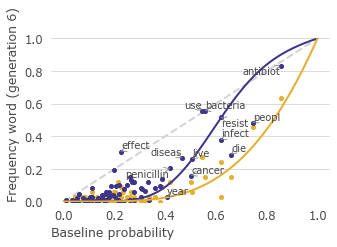

In [18]:
# Get data of transmission at word level (see 1_data_processing)
all_persons = pd.read_csv(f'{path_data_files}/data_processing/transmissions_word_level.csv')

# For the comparison generation, get the number of times each word appears
x = all_persons.loc[(all_persons["layer_n"]==comparison_layer) & (all_persons["transmitted"]==True) , ["condition","word","transmitted","number_stories_observed"]].groupby(["condition"])["word"].value_counts()
x = x.unstack().stack(dropna=False).reset_index()
x.columns = ["condition","word","freq"]
print(x.loc[x["word"]=="antibiot"])

# Calculate total number of replicates
number_replicates_person = results.loc[results['layer_n']==comparison_layer, "condition"].value_counts()
print(number_replicates_person)

# Normalize
x.loc[x["condition"]=="Chain", "freq"] /= number_replicates_person["Chain"]
x.loc[x["condition"]=="Network", "freq"] /= number_replicates_person["Network"]

# Merge with the baseline probabilities
y = pd.merge(x, base_freqs[["word","baseline_prob_3_word_265"]], how="outer").dropna(subset=["condition"]).fillna(0)

# Plot the found frequencies vs the baseline probaiblity
for condition in ["Chain", "Network"]:
    plt.plot(y.loc[y["condition"]==condition, "baseline_prob_3_word_265"], 
             y.loc[y["condition"]==condition, "freq"], 
             ".",
             color = cond2color[condition], markersize=8)
plt.xlabel("Baseline probability")
plt.ylabel("Frequency word (generation 6)")
plt.gca().grid(axis='y')

# Annotate the words
texts = []
y_annotate = y.loc[((y["baseline_prob_3_word_265"]>0.4) | (y["freq"]>0.3)) & (y["condition"] == "Network")].groupby("word").mean()
for word, row in y_annotate.iterrows():
    texts.append(plt.text(row["baseline_prob_3_word_265"], row["freq"], word, va="center", fontsize=10))
    
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Add expected from the deterministic model
plt.plot(np.linspace(0,1,100), time_to_extinguishment)#, label="Network (model)")
plt.plot(np.linspace(0,1,100), time_to_extinguishment_c)#, label="Chain (model)")
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"--", color="lightgray",zorder=0)
plt.legend()
plt.ylim(0,1)
plt.savefig(f"{path_figures}/statistical_model_plus_abm.pdf", bbox_inches="tight")



### Comparing stochastic transmission rule to deterministic rules

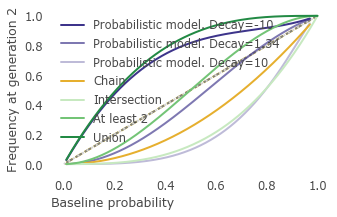

In [21]:
# Plot the deterministic model too
prob = np.linspace(0.01,0.97,1000)

for i, decay in enumerate([-10, 1.34, 10]):
    for n_remembered in np.arange(1,4)/3:
        r = create_prob(prob, network=1, n_remembered=n_remembered, n_words=256, beta_n_observed=decay)
    
        #plt.plot(prob, 100*r, label=f"Network: Word read {3*n_remembered} time{['s',''][int(3*n_remembered==1)]}", color=colors.pop(0))
        if n_remembered == 1/3:
            cum = 3*prob*(1-prob)**2*r ##binom.pmf(range(4), 3, p)]
        elif n_remembered == 2/3:
            cum += 3*prob**2*(1-prob)*r
        else:
            cum += 1*prob**3*r
    
    plt.plot(prob, cum, color=palette[0], alpha=1-i/3, label=f"Probabilistic model. Decay={decay}")

prob_after = create_prob(prob, network=0, n_remembered=n_remembered, n_words=256)
plt.plot(prob, prob*prob_after, color=palette[1],  label=f"Chain")

# Plot the deterministic model too
deterministic_model_plot(3, xmin=0.01, generations=1)


plt.legend(loc=2)
plt.xlabel("Baseline probability")
plt.ylabel("Frequency at generation 2")
plt.plot([0,1],[0,1],":", color="lightgray", zorder=0)
plt.title("")
plt.savefig(f"{path_figures}/appendix_statistical_model_two_layers.pdf", bbox_inches="tight") 

